In [1]:
import ast
import graphviz
import inspect
import numpy
import pystan
import sys

def parse_model(python_function):
    dot = graphviz.Digraph()
    dot.attr('graph', rankdir='LR')
    class PythonAstVisitor(ast.NodeVisitor):
        def __init__(self):
            self.indent = 0
            self.label = None
            self.identifiers = []
        def generic_visit(self, node):
            result = self.indentation()
            kind = type(node).__name__
            if self.label is None:
                result += '//missing visit method for {}\n'.format(kind)
            else:
                result += '//{} = {}\n'.format(self.label, kind)
            self.indent += 1
            for name, value in ast.iter_fields(node):
                if isinstance(value, ast.AST):
                    self.label = name
                    result += self.visit(value)
                elif isinstance(value, list):
                    for i in range(len(value)):
                        self.label = '{}[{:d}]'.format(name, i)
                        result += self.visit(value[i])
                else:
                    result += self.indentation()
                    result += '//{} = {}\n'.format(name, value)
            self.indent -= 1
            self.label = None
            return result
        def indentation(self):
            return ''.join(['  ' for _ in range(self.indent)])
        def visit_AnnAssign(self, node):
            #eg. 'x: int(lower=0,upper=1)[10]' -> 'int<lower=0,upper=1> x[10];'
            assert node.value is None and node.simple == 1
            identifier = self.visit(node.target)
            dot.attr('node', shape='circle', style='filled', fillcolor='white')
            dot.node(identifier)
            typ, dims = self.visit_annotation(node.annotation)
            return 'parameters', self.indentation() + typ + ' ' + identifier + dims + ';\n'
        def visit_annotation(self, node):
            if isinstance(node, ast.Subscript):
                type_ast = node.value
                dims = '[{:d}]'.format(node.slice.value.n)
            else:
                type_ast = node
                dims = ''
            if isinstance(type_ast, ast.Call):
                typ = type_ast.func.id + '<'
                for i in range(len(type_ast.keywords)):
                    if i > 0:
                        typ += ', '
                    typ += self.visit(type_ast.keywords[i])
                typ += '>'
            else:
                typ = self.visit(type_ast)
            return typ, dims
        def visit_arg(self, node):
            identifier = node.arg
            dot.attr('node', shape='circle', style='filled', fillcolor='lightgray')
            dot.node(identifier)
            typ, dims = self.visit_annotation(node.annotation)
            return self.indentation() + typ + ' ' + identifier + dims + ';\n'
        def visit_arguments(self, node):
            result = ''
            for arg in node.args:
                result += self.visit(arg)
            return result
        def visit_Assign(self, node):
            #eg. 'x[i] =~ bernoulli(theta)' -> 'x[i] ~ bernoulli(theta);'
            indent = self.indentation()
            assert len(node.targets) == 1
            self.identifiers = []
            lhs = self.visit(node.targets[0])
            definitions = self.identifiers
            self.identifiers = []
            if isinstance(node.value, ast.UnaryOp):
                assert isinstance(node.value.op, ast.Invert)
                op = '~'
                rhs = self.visit(node.value.operand)
            else:
                op = '='
                rhs = self.visit(node.targets[0])
            uses = self.identifiers
            for use in uses:
                for definition in definitions:
                    dot.edge(use, definition)
            return 'model', '{}{} {} {};\n'.format(indent, lhs, op, rhs)
        def visit_Call(self, node):
            if node.func.id is 'range':
                assert(len(node.args) == 1)
                upper = self.visit(node.args[0])
                result = '1:' + upper
            else:
                result = node.func.id + '('
                for i in range(len(node.args)):
                    if i > 0:
                        result += ', '
                    result += self.visit(node.args[i])
                result += ')'
            return result
        def visit_For(self, node):
            indent = self.indentation()
            tgt = node.target.id
            src = self.visit(node.iter)
            head = '{}for ({} in {})\n'.format(indent, tgt, src)
            assert len(node.body) == 1
            self.indent += 1
            label, contents = self.visit(node.body[0])
            self.indent -= 1
            return 'model', head + contents
        def visit_FunctionDef(self, node):
            block_labels = ['data', 'transformed data', 'parameters',
                'transformed parameters', 'model', 'generated quantities']
            blocks = { label: '' for label in block_labels }
            self.indent = 1
            blocks['data'] = self.visit(node.args)
            for stmt in node.body:
                label, contents = self.visit(stmt)
                blocks[label] += contents
            self.indent = 0
            result = ''
            for label in block_labels:
                if blocks[label] != '':
                    result += label + ' {\n' + blocks[label] + '}\n'
            return result
        def visit_Index(self, node):
            if isinstance(node.value, ast.Name):
                return node.value.id
            return self.visit(node.value)
        def visit_keyword(self, node):
            lhs = node.arg
            rhs = self.visit(node.value)
            return '{}={}'.format(lhs, rhs)
        def visit_Module(self, node):
            assert len(node.body) == 1
            return self.visit(node.body[0])[:-1]
        def visit_Name(self, node):
            self.identifiers.append(node.id)
            return node.id
        def visit_Num(self, node):
            return str(node.n)
        def visit_Subscript(self, node):
            base = self.visit(node.value)
            index = self.visit(node.slice)
            return '{}[{}]'.format(base, index)
    source = inspect.getsource(python_function)
    tree = ast.parse(source)
    visitor = PythonAstVisitor()
    return dot, visitor.visit(tree)

def dummy_type(**kwargs):
    class DummyList:
        def __getitem__(self, key):
            return None
    return DummyList()

int = dummy_type

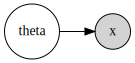

In [2]:
def coin_model_py(x: int(lower=0, upper=1)[10]):
    theta: real(lower=0, upper=1)
    theta = ~ uniform(0, 1)
    for i in range(10):
        x[i] =~ bernoulli(theta)

coin_model_viz, coin_model_stan = parse_model(coin_model_py)

coin_model_viz

In [3]:
real = [1,2,3]
N = 0
def yaps(fn):
    pass

@yaps
def slicstan_example(N: int, y: real[N]):
    with parameters:
        tau: real <~ gamma(0.1, 0.1)
        mu: real <~ normal(0, 1)
    with transformed_parameters:
        sigma: real = pow(tau, -0.5)
    with model:
        y <~ normal(mu, sigma)
        v: gquant(real) = pow(sigma, 2)

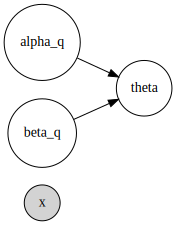

In [4]:
def coin_guide_py(x: int(lower=0, upper=1)[10]):
    alpha_q: real(lower=0, variational=True)
    beta_q: real(lower=0, variational=True)
    theta =~ beta(alpha_q, beta_q)

coin_guide_viz, coin_guide_stan = parse_model(coin_guide_py)

coin_guide_viz

In [5]:
print(coin_model_stan)

data {
  int<lower=0, upper=1> x[10];
}
parameters {
  real<lower=0, upper=1> theta;
}
model {
  theta ~ uniform(0, 1);
  for (i in 1:10)
    x[i] ~ bernoulli(theta);
}


In [7]:
data = {'x': [0, 1, 0, 0, 0, 0, 0, 0, 0, 1]}

fit = pystan.stan(model_code=coin_model_stan, data=data, iter=1000)

samples = fit.extract()['theta']

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_23c02817c2eb1a7a80f12fd5acdd643e NOW.


In [8]:
print("Posterior mean:", numpy.mean(samples))
print("Posterior stddev:", numpy.std(samples))

Posterior mean: 0.2522495058219269
Posterior stddev: 0.12107639770715897
